In [123]:
%matplotlib inline
from multisim.multisim import *
import matplotlib.pyplot as plt
from scipy.linalg import expm, inv

from multisim.mpc import mpc

In [124]:
# set up system
nsteps = 500

tfaulton  = 0.1
tfaultoff = 0.3
tend      = 4.0

time   = np.linspace(0,tend,nsteps)
step   = time[1]

time_1 = [t for t in time if t < tfaulton]
time_2 = [t for t in time if t > tfaulton and t < tfaultoff]
time_3 = [t for t in time if t > tfaultoff]


# create system: this can be a file that we parse
dsystem = System()
dsystem.silent()

for i in range(2):
    dsystem.addbus(i)

dsystem.buses[0].setvinit(cmath.rect(1.04, 0))
dsystem.buses[1].setvinit(cmath.rect(1.01613, (np.pi/180.0)*-3.3252))

dsystem.addbranch(0, 1, 0.0001, 0.0576)
dsystem.createYbusReal()

gen1 = GenCLS(0, 5.0, 1.0)
gen1.setinitpow(1.06496, 0.45996)

load = ZLoad(1, (1.03123 + 1j*-0.37616))

dsystem.adddevice(gen1)

dsystem.addload(load)

In [125]:
def discrete_system(x, dt):
    JX = np.zeros((2, 2))
    JU = np.zeros((2, 1))
    
    delta = x[0]
    w     = x[1]
    vr    = x[6]
    vi    = x[7]

    vt = np.abs(vr + 1j*vi)
    theta = cmath.phase(vr + 1j*vi)
    
    xd = 1.0
    eq = 1.80158210262
    H  = 1.0
    
    JX[0, 1] = 2*np.pi*60.0
    JX[1, 0] = (-vt*eq*np.cos(delta - theta))/(2.0*xd*H)
    
    JU[1] = 1/(2.0*H)
    
    #Am = np.eye(JX.shape[0]) + dt*JX
    #Bm = dt*JU
    A = expm(dt*JX)
    B = np.dot(inv(JX), A - np.eye(2))
    B = np.dot(B, JU)
    
    return A, B

In [126]:
def generator_control(A, B, xdelta):
    
    n = 2 # state dimension
    m = 1  # input dimension

    T = 50
    kappa  = 0.01
    niter = 5
    quiet  = 1.0

    A = np.asfortranarray(A)
    B = np.asfortranarray(B)

    Q = np.asfortranarray(np.eye(n))
    Q[1, 1] = 10.0
    R = np.asfortranarray(np.eye(m))       

    xmin = -900*np.ones(n)
    xmax =  900*np.ones(n)
    umin = -0.2*np.ones(m)
    umax = 0.2*np.ones(m)

    Qf     = Q

    X = np.zeros((n,T), order = 'F')
    U = np.zeros((m,T), order = 'F')

    X0 = np.zeros((n,T), order = 'F')
    U0 = np.zeros((m,T), order = 'F')

    x = np.array([xdelta[0], xdelta[1]], dtype = np.float64)
    mpc.mpc_step(A, B, Q, R, xmax, xmin, umax, umin, n, m, T, Qf, kappa, niter, quiet, X0, U0, x, X, U, 0.1)
    
    return U[:, 0]

In [127]:
# Solve system
x = initialize_system(dsystem)

# allocate array for trajectory plus steady-state solutions
trajectory = np.zeros((len(x), len(time) + 2))
trajectory[:,0] = np.copy(x)

# prepare variable to index array
k = 0

# integrate to t_on
for i in range(len(time_1)):
    trajectory[:, i + 1] = propagate_system(trajectory[:, i], dsystem, step)
    
    # control loop
    xdelta  = trajectory[:, i + 1] - trajectory[:, i]
    A, B    = discrete_system(trajectory[:, i + 1], step)
    u       = generator_control(A, B, xdelta)
    #print "At time: %g apply control: %g" % (time_1[i], u)
    
    k = k + 1
    
# apply fault
fault_id = dsystem.applyBusFault(1, 0.01)
x = solve_steady_system(trajectory[:, k - 1], dsystem)
trajectory[:, k] = np.copy(x)

# integrate to t_off
for i in range(len(time_2)):
    trajectory[:, k + 1] = propagate_system(trajectory[:, k], dsystem, step)

    # control loop
    if (i%10 == 0):
        xdelta = trajectory[:, k + 1] - trajectory[:, k - 10]
        A, B   = discrete_system(trajectory[:, k + 1], step)
        u      = generator_control(A, B, xdelta)
        dsystem.devices[0].p_m += u
        print dsystem.devices[0].p_m
    
    k  = k + 1
    
    #print "At time: %g apply control: %g" % (time_2[i], u)


    
# remove fault
dsystem.removeBusFault(fault_id)
x = solve_steady_system(trajectory[:, k - 1], dsystem)
trajectory[:, k] = np.copy(x)

# integrate to t_end
for i in range(len(time_3)):
    trajectory[:, k + 1] = propagate_system(trajectory[:, k], dsystem, step)
    
    # control loop
    if (i%10 == 0):
        xdelta = trajectory[:, k + 1] - trajectory[:, k - 10]
        A, B   = discrete_system(trajectory[:, k + 1], step)
        u      = generator_control(A, B, xdelta)
        dsystem.devices[0].p_m += u
        print dsystem.devices[0].p_m
    
    k  = k + 1

1.80158210262 1.06496
>>>APPLYING FAULT at bus: 1, z: 0.01.
Solve steady state
[ 1.06496]
[ 0.889039]
[ 0.70166808]
<<<REMOVING FAULT at bus: 1, z: 0.01.
Solve steady state
[ 0.55361953]
[ 0.57222626]
[ 0.59904341]
[ 0.63492777]
[ 0.6817379]
[ 0.6817379]
[ 0.6817379]
[ 0.77284155]
[ 0.86234083]
[ 0.94875979]
[ 1.02764685]
[ 1.09671768]
[ 1.1545339]
[ 1.20061713]
[ 1.23509123]
[ 1.25858103]
[ 1.27120802]
[ 1.27480869]
[ 1.26845211]
[ 1.26845211]
[ 1.26845211]
[ 1.26845211]
[ 1.26845211]
[ 1.21761061]
[ 1.16611746]
[ 1.11706999]
[ 1.07236408]
[ 1.03342901]
[ 1.0012374]
[ 0.97632387]
[ 0.95882067]
[ 0.94850675]
[ 0.94486599]
[ 0.94486599]
[ 0.94486599]
[ 0.94486599]
[ 0.94486599]
[ 0.94486599]
[ 0.94486599]
[ 0.94486599]
[ 0.98456964]
[ 1.0230462]
[ 1.05816391]
[ 1.08878389]
[ 1.11413551]
[ 1.13379198]
[ 1.1476425]


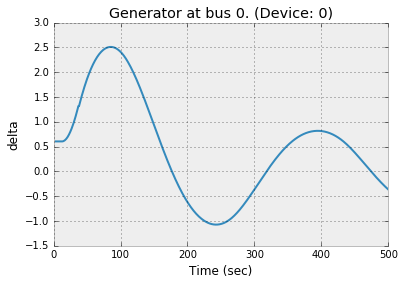

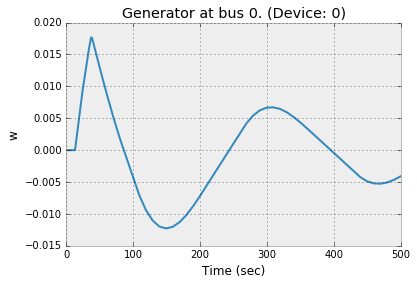

In [128]:
generator_plots(dsystem, trajectory[:,:-1], 0)